!["Toyota"](../Used_Car_Price_Regression_Model/Images/johnathan-ciarrocca-x3HRBLzCmBU-unsplash.jpg)

# Used Toyota Price Regression Model

# Introduction

This dataset comes from a collection of UK Used Car listing that were scraped and assembled for use. I chose to start off with the Toyota dataset because I happen to own one myself. The price is in English Pounds but for the use of this notebook I don't think I will be dealing with it - though I suppose I could figure out how to determine the exchange rate into Dollars depending on the year. I'm more interested in doing some EDA of the dataset and then building some Regression Models. Perhaps my model could one day estimate how much my own Toyota is worth!

# Libraries

In [1]:
# Below are the libraries I will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from  sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Load Data

In [2]:
# Load the data
df = pd.read_csv("toyota.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [3]:
# How many rows/columns are there?
df.shape

(6738, 9)

In [4]:
# Pretty clean data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [5]:
# Maybe some outliers
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


# EDA

The dataset has 9 features:

* 5 numerical columns: 'price', 'mileage', 'tax', 'mpg' and 'engineSize'
* 3 categorical columns: 'model', 'transmission' and 'fuelType'
* 1 date column: 'year'

In [6]:
# The documentation said it didn't have any null values but I still wanted to check.
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [7]:
# Check for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

39


In [8]:
# Drop all duplicates
df.drop_duplicates(keep='first',inplace=True)

In [9]:
df.shape

(6699, 9)

## Heteroskedasticity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9e3eaf310>,
      dtype=object)

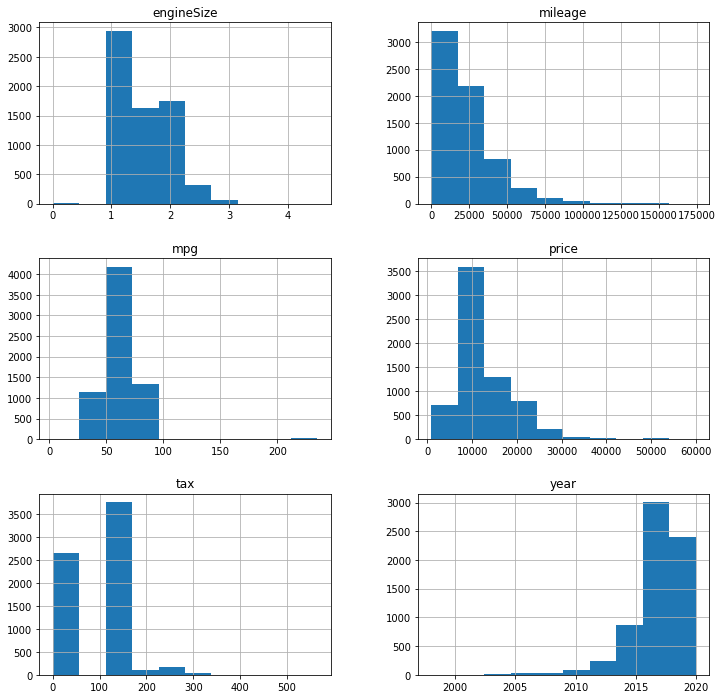

In [10]:
# Histograms to view heteroskedasticity
df.hist(figsize=(12,12))

Most of the continuous features are pretty skewed. Later I will use Standard Scaler to correct this.

## Multicollinearity of Features

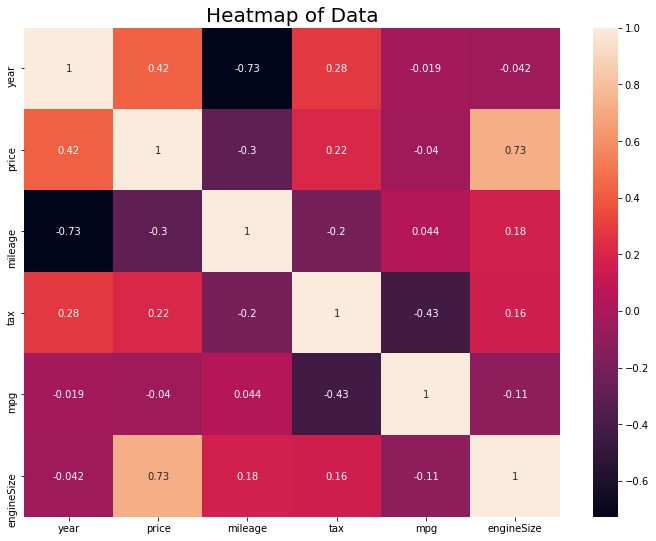

In [11]:
# Heatmap Correlation
fig = plt.figure(figsize = (12,9))
sns.heatmap(df.corr(), annot=True)
plt.title('Heatmap of Data', fontsize = 20)
plt.show()

Mileage and year have a negative correlation - which makes sense. The older the car and the more miles it has the more the price goes down.
Price and engine size have a positive correlation. Meaning that the bigger the engine the more expensive. 

## Linearity

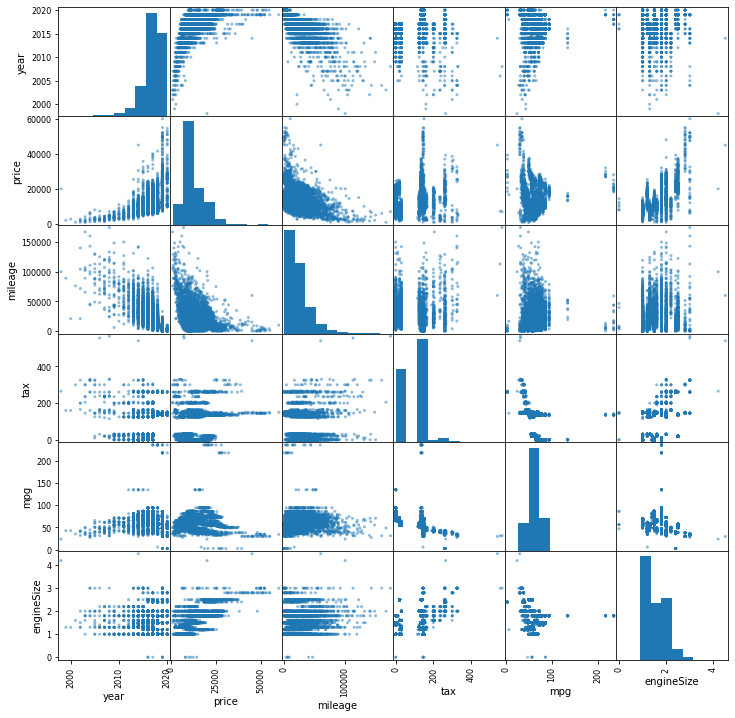

In [12]:
# Scatter matrix of all the features
pd.plotting.scatter_matrix(df, figsize=(12,12));

The features 'year' vs. 'mileage' seems pretty linear (with a negative relationship).
As well, 'year' vs. 'price' seems linear.

# Categorical Data

In [13]:
# Check out the different models - looks like 18 types.
df['model'].value_counts()

 Yaris            2117
 Aygo             1940
 Auris             709
 C-HR              479
 RAV4              467
 Corolla           265
 Prius             232
 Avensis           114
 Verso             114
 Hilux              85
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

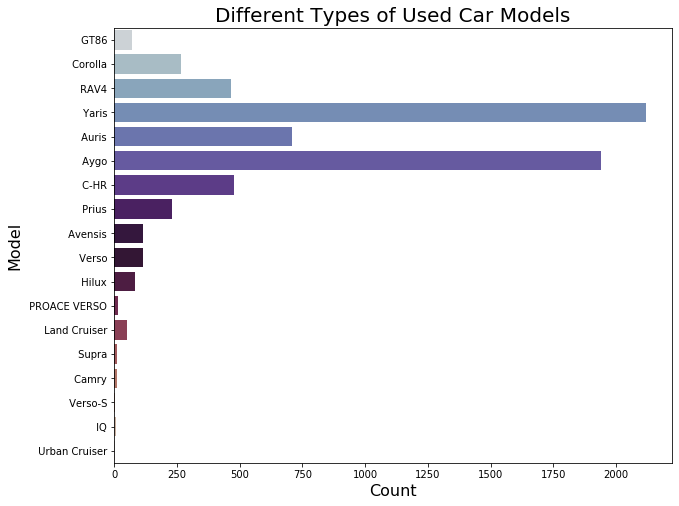

In [14]:
# Which are the most common in the dataset - 'Yaris' and 'Aygo'
fig = plt.figure(figsize = (10,8))
sns.countplot(y=df['model'], palette="twilight")
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Model", fontsize = 16)
plt.title("Different Types of Used Car Models", fontsize = 20)
plt.show()

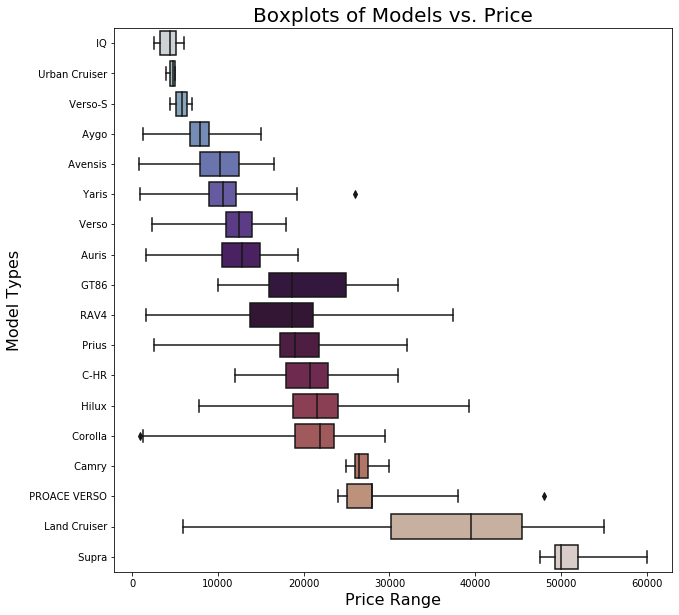

In [15]:
# How do their prices compare to other models?
fig = plt.figure(figsize = (10,10))
sns.boxplot(x="price", y="model", whis=4, data=df, palette="twilight",
           order = df.groupby('model').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Model Types", fontsize = 16)
plt.title("Boxplots of Models vs. Price", fontsize = 20)
plt.show()

In [16]:
# Types of transmissions
df['transmission'].value_counts()

Manual       3793
Automatic    2651
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

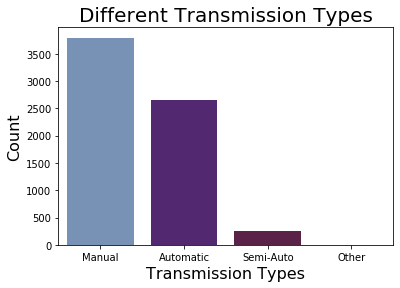

In [17]:
# Manual cars are still most common in the UK?
sns.countplot(df['transmission'],palette="twilight")
plt.xlabel("Transmission Types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Transmission Types", fontsize = 20)
plt.show()

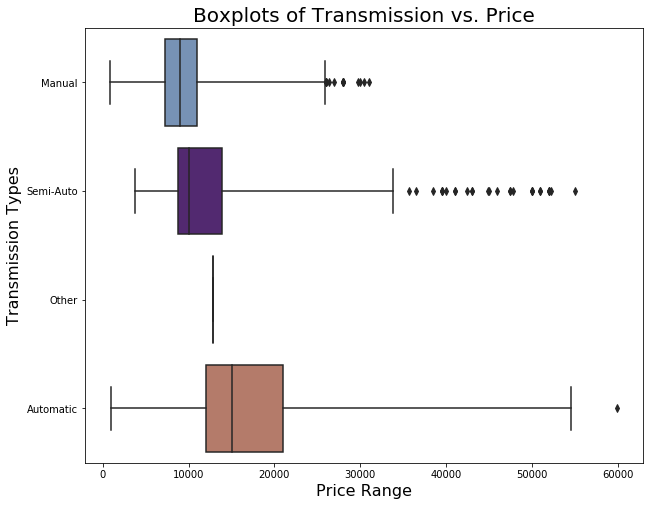

In [18]:
# Manual cars seem to be slightly cheaper than other types
fig = plt.figure(figsize = (10,8))
sns.boxplot(x="price", y="transmission", whis=4, data=df, palette="twilight",
           order = df.groupby('transmission').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Transmission Types", fontsize = 16)
plt.title("Boxplots of Transmission vs. Price", fontsize = 20)
plt.show()

In [19]:
# What is this 'Other' fuel type? Electric?
df['fuelType'].value_counts()

Petrol    4058
Hybrid    2040
Diesel     496
Other      105
Name: fuelType, dtype: int64

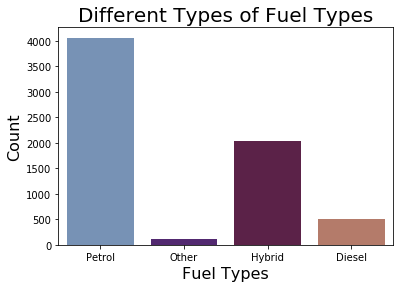

In [20]:
# Standard gas cars and the most common
sns.countplot(df['fuelType'],palette="twilight")
plt.xlabel("Fuel Types", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Types of Fuel Types", fontsize = 20)
plt.show()

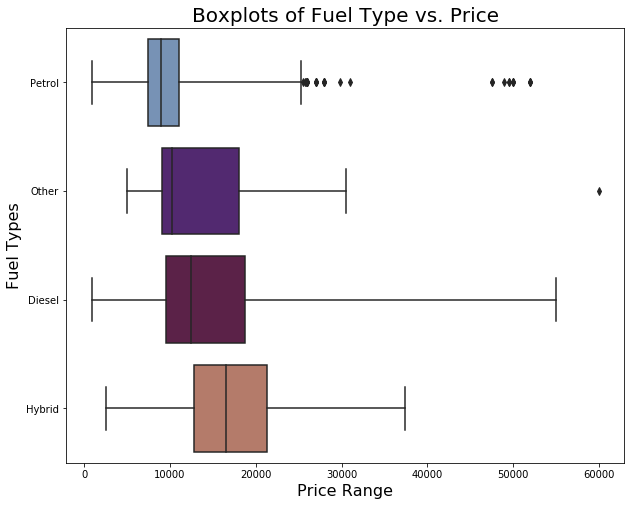

In [21]:
# Hybrids are the most expensive on average.
fig = plt.figure(figsize = (10,8))
sns.boxplot(x="price", y="fuelType", whis=4, data=df, palette="twilight",
           order = df.groupby('fuelType').median().sort_values(by = 'price').index)
plt.xlabel("Price Range", fontsize = 16)
plt.ylabel("Fuel Types", fontsize = 16)
plt.title("Boxplots of Fuel Type vs. Price", fontsize = 20)
plt.show()

## Date Column

In [22]:
# Should I put this into a datetime column?
df.year.describe()

count    6699.000000
mean     2016.742797
std         2.205271
min      1998.000000
25%      2016.000000
50%      2017.000000
75%      2018.000000
max      2020.000000
Name: year, dtype: float64

In [23]:
# What am I going to do with this 'year' feature?
df['year'].value_counts()

2017    2015
2019    1265
2018    1014
2016     990
2015     522
2014     351
2013     203
2020     127
2012      42
2011      40
2009      29
2007      20
2008      19
2010      18
2005      12
2006      11
2004       7
2003       6
2002       4
1998       1
2001       1
1999       1
2000       1
Name: year, dtype: int64

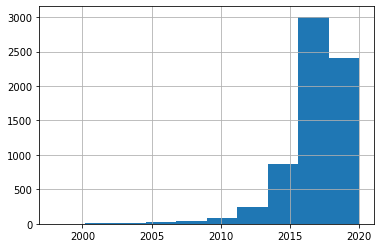

In [24]:
# Looks pretty skewed left.
df.year.hist()

In [25]:
# Three std below the mean
df.year.mean() - df.year.std()*3

2010.1269853273777

In [26]:
# How many are there?
len(df.loc[df["year"] < 2010])

112

In [27]:
# Let's get rid of the outliers
df = df[df.year > 2010]

In [28]:
# Make a new integer column of car age.
df['carAge'] = 2020 - df['year']
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0,4
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0,3
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0,5
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0,3
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0,3


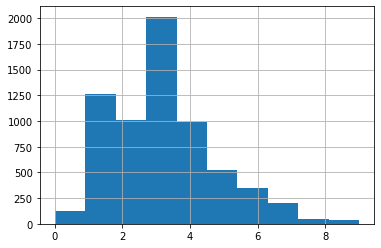

In [29]:
# Looks better
df.carAge.hist()

In [30]:
# Is this age integer any different than the year?
df = df.drop('year', axis=1)
df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge
0,GT86,16000,Manual,24089,Petrol,265,36.2,2.0,4
1,GT86,15995,Manual,18615,Petrol,145,36.2,2.0,3
2,GT86,13998,Manual,27469,Petrol,265,36.2,2.0,5
3,GT86,18998,Manual,14736,Petrol,150,36.2,2.0,3
4,GT86,17498,Manual,36284,Petrol,145,36.2,2.0,3


## Binning Categorical Data

In [31]:
# Use One Hot Encoding to change all categorical data to 0 and 1's
final_df = pd.concat([df, pd.get_dummies(df.model, drop_first=True),
                          pd.get_dummies(df.fuelType, drop_first=True), 
                          pd.get_dummies(df.transmission, drop_first=True)], 
                     axis = 1)
final_df.head()

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize,carAge,Avensis,...,Urban Cruiser,Verso,Verso-S,Yaris,Hybrid,Other,Petrol,Manual,Other,Semi-Auto
0,GT86,16000,Manual,24089,Petrol,265,36.2,2.0,4,0,...,0,0,0,0,0,0,1,1,0,0
1,GT86,15995,Manual,18615,Petrol,145,36.2,2.0,3,0,...,0,0,0,0,0,0,1,1,0,0
2,GT86,13998,Manual,27469,Petrol,265,36.2,2.0,5,0,...,0,0,0,0,0,0,1,1,0,0
3,GT86,18998,Manual,14736,Petrol,150,36.2,2.0,3,0,...,0,0,0,0,0,0,1,1,0,0
4,GT86,17498,Manual,36284,Petrol,145,36.2,2.0,3,0,...,0,0,0,0,0,0,1,1,0,0


In [32]:
# Get rid of columns we don't need
final_df =  final_df.drop(['model','transmission','fuelType'], axis = 1)

In [33]:
# This will be our new df
final_df.head()

,price,mileage,tax,mpg,engineSize,carAge,Avensis,Aygo,C-HR,Camry,...,Urban Cruiser,Verso,Verso-S,Yaris,Hybrid,Other,Petrol,Manual,Other,Semi-Auto
0,16000,24089,265,36.2,2.0,4,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,15995,18615,145,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,13998,27469,265,36.2,2.0,5,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,18998,14736,150,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,17498,36284,145,36.2,2.0,3,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


# Continuous Data

In [34]:
# We know that engine size is a good predictore of price
df['engineSize'].value_counts()

1.0    2010
1.5    1414
1.8    1266
1.3     570
2.0     378
1.2     300
2.5     247
1.6     156
2.4      70
2.2      49
1.4      37
2.8      36
3.0      29
0.0       6
4.5       1
Name: engineSize, dtype: int64

In [35]:
df.engineSize.describe()

count    6569.000000
mean        1.469600
std         0.433259
min         0.000000
25%         1.000000
50%         1.500000
75%         1.800000
max         4.500000
Name: engineSize, dtype: float64

In [36]:
df.engineSize.unique()

array([2. , 1.8, 1.2, 2.5, 2.2, 1.5, 1. , 1.3, 1.4, 0. , 1.6, 2.4, 3. ,
       2.8, 4.5])

In [37]:
# Three std above the mean
df.engineSize.mean() + df.engineSize.std()*3

2.769375417766054

In [38]:
# How many are there?
len(df.loc[df["engineSize"] > 2.75])

66

In [39]:
# Let's get rid of the outliers
df = df[df.engineSize < 2.75]

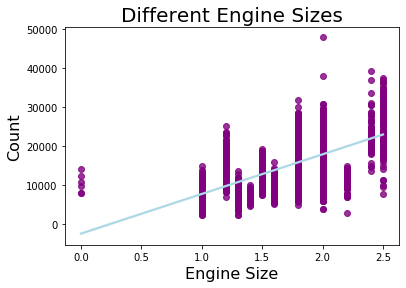

In [40]:
# This regplot shows the direct relationship of price and engine size.
sns.regplot(data=df, x="engineSize", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Engine Size", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Engine Sizes", fontsize = 20)
plt.show()

In [41]:
# Are we sure these values aren't in kilometers? But the UK uses miles and gallons!
df['mpg'].value_counts()

69.0    674
68.9    472
56.5    464
47.9    408
74.3    362
       ... 
44.1      3
51.3      2
83.1      1
37.7      1
6.0       1
Name: mpg, Length: 65, dtype: int64

In [42]:
df.mpg.describe()

count    6503.000000
mean       63.654867
std        15.599875
min         2.800000
25%        56.500000
50%        65.600000
75%        70.600000
max       235.000000
Name: mpg, dtype: float64

In [43]:
# Three std above the mean
df.mpg.mean() + df.mpg.std()*3

110.45449170582927

In [44]:
# How many are there?
len(df.loc[df["mpg"] > 110.91])

30

In [45]:
# Let's get rid of the outliers
df = df[df.mpg < 110.91]

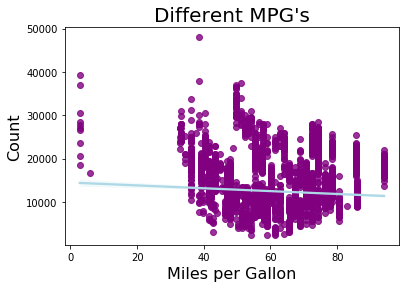

In [46]:
# I would think that higher miles per gallon would decrease the price?
sns.regplot(data=df, x="mpg", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Miles per Gallon", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different MPG's", fontsize = 20)
plt.show()

In [47]:
# Should I get rid of the outliers?
df['mileage'].describe()

count      6473.000000
mean      21762.968175
std       16819.505114
min           2.000000
25%        9416.000000
50%       18089.000000
75%       30159.000000
max      150000.000000
Name: mileage, dtype: float64

In [48]:
# Three std above the mean
df.mileage.mean() + df.mileage.std()*3

72221.48351736192

In [49]:
# How many are there?
len(df.loc[df["mileage"] > 72427.81])

87

In [50]:
# Let's get rid of the outliers
df = df[df.mileage < 72427.81]

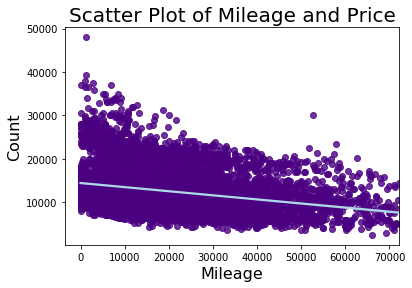

In [51]:
# A slight negative relationship here
sns.regplot(data=df, x="mileage", y="price", scatter_kws={"color": "indigo"}, line_kws={"color": "lightblue"})
plt.xlabel("Mileage", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Scatter Plot of Mileage and Price", fontsize = 20)
plt.show()

In [52]:
# Should I bin these - they don't seem continuous?
df['tax'].value_counts()

145    2018
0      1737
135     660
30      563
150     516
20      221
140     216
125     184
260      70
200      61
265      38
160      29
205      25
10       18
165      18
235       8
300       2
240       1
250       1
Name: tax, dtype: int64

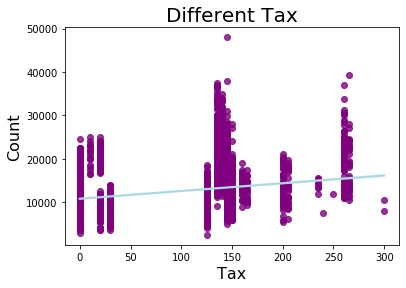

In [53]:
# Not sure how cars are taxed in the UK.
sns.regplot(data=df, x="tax", y="price", scatter_kws={"color": "purple"}, line_kws={"color": "lightblue"})
plt.xlabel("Tax", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Different Tax", fontsize = 20)
plt.show()

In [54]:
df.tax.describe()

count    6386.000000
mean       92.391951
std        70.932195
min         0.000000
25%         0.000000
50%       135.000000
75%       145.000000
max       300.000000
Name: tax, dtype: float64

In [55]:
# Three std above the mean
df.tax.mean() + df.tax.std()*3

305.1885373039288

In [56]:
# How many are there?
len(df.loc[df["tax"] > 305.18])

0

In [57]:
# Let's get rid of the outliers
df = df[df.tax < 305.18]

## Log Transformations on skewed histograms

Text(0.5, 1.0, 'mpg')

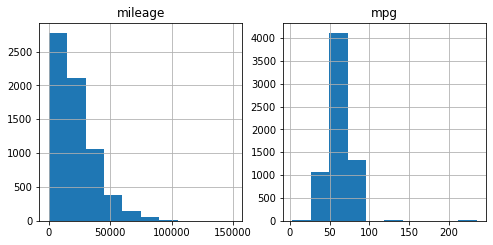

In [58]:
# I just want to look at a couple of these again BEFORE the transformation.
new_figure = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2, 2, 1)
final_df.mileage.hist(ax=ax1)
ax1.set_title("mileage")

ax3 = plt.subplot(2, 2, 2)
final_df.mpg.hist(ax=ax3)
ax3.set_title("mpg")

In [59]:
# Perform log transformation
#logmpg = np.log(df["mpg"])
#logmileage = np.log(df["mileage"])

# Switch the standardization into the final data
#final_df["mpg"] = (logmpg-np.mean(logmpg))/np.sqrt(np.var(logmpg))
#final_df["mileage"] = (logmileage-np.mean(logmileage))/np.sqrt(np.var(logmileage))

Text(0.5, 1.0, 'mpg')

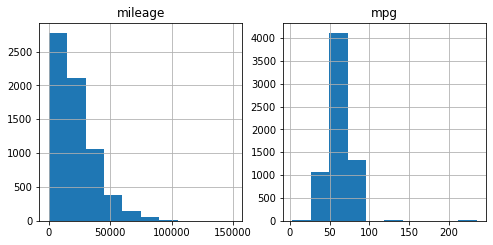

In [60]:
# I just want to look at a couple of these again AFTER the transformation.
new_figure = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2, 2, 1)
final_df.mileage.hist(ax=ax1)
ax1.set_title("mileage")

ax3 = plt.subplot(2, 2, 2)
final_df.mpg.hist(ax=ax3)
ax3.set_title("mpg")

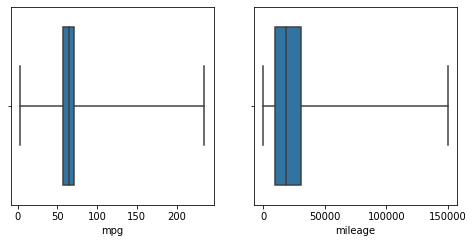

In [61]:
# I just want to look at a couple of these again BEFORE the transformation.
new_figure = plt.figure(figsize=(8,8))

ax1 = plt.subplot(2, 2, 1)
sns.boxplot(x='mpg', whis=[0,100], data=final_df)

ax3 = plt.subplot(2, 2, 2)
sns.boxplot(x='mileage', whis=[0,100], data=final_df)


# Test/Train Split

In [62]:
y = final_df['price']

In [63]:
y.head()

0    16000
1    15995
2    13998
3    18998
4    17498
Name: price, dtype: int64

In [64]:
X = final_df.drop('price', axis=1)

In [65]:
X.head()

,mileage,tax,mpg,engineSize,carAge,Avensis,Aygo,C-HR,Camry,Corolla,...,Urban Cruiser,Verso,Verso-S,Yaris,Hybrid,Other,Petrol,Manual,Other,Semi-Auto
0,24089,265,36.2,2.0,4,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,18615,145,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,27469,265,36.2,2.0,5,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,14736,150,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,36284,145,36.2,2.0,3,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [66]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [67]:
X_train

,mileage,tax,mpg,engineSize,carAge,Avensis,Aygo,C-HR,Camry,Corolla,...,Urban Cruiser,Verso,Verso-S,Yaris,Hybrid,Other,Petrol,Manual,Other,Semi-Auto
1863,34748,0,78.0,1.5,4,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2992,28453,135,78.5,1.8,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2293,6817,145,47.9,1.5,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4016,1118,150,57.7,1.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
6134,17681,135,235.0,1.8,3,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,11620,145,69.0,1.0,3,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4158,19057,145,69.0,1.0,2,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1382,15772,145,58.9,1.5,2,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3545,29000,0,72.4,1.8,6,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Standard Scaler

In [69]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

# sklearn Models

## Linear Regression Model

In [71]:
linreg = LinearRegression()

# Linear Regression
linreg = LinearRegression()

# Fit
linreg.fit(X_train, y_train)

# Predict
pred = linreg.predict(X_test)

# RMSE
np.sqrt(mean_squared_error(y_test, pred))

1533.7749776660726

## Decision Tree Regressor Model

In [72]:
# Decision tree
dt = DecisionTreeRegressor(max_depth=10,random_state=123)

# Fit
dt.fit(X_train, y_train)

# Predict
pred = dt.predict(X_test)

# RMSE
np.sqrt(mean_squared_error(y_test, pred))

1381.4027146944627

## Support Vector Regressor

In [73]:
# SVR
svr = SVR(kernel='rbf', C=5)

# Fit
svr.fit(X_train, y_train)

# Predict
pred = svr.predict(X_test)

# RMSE
np.sqrt(mean_squared_error(y_test, pred))


5466.440998022445

## KNeighborsRegressor Model

In [82]:
# KNN Regressor
knn = KNeighborsRegressor()

# Fit
knn.fit(X_train, y_train)

# Predict
pred = knn.predict(X_test)

# RMSE
np.sqrt(mean_squared_error(y_test, pred))


6612.65663266986

# Statsmodel's OLS (Ordinary Least Squares) Model

In [85]:
model = sm.OLS(y_train, X_train).fit()

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              943.3
Date:                Thu, 15 Oct 2020   Prob (F-statistic):                   1.25e-269
Time:                        10:33:58   Log-Likelihood:                         -2887.1
No. Observations:                 328   AIC:                                      5822.
Df Residuals:                     304   BIC:                                      5913.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
mileage           -0.0542      0.008     -6.679      0.000      -0.070      -0.038
tax               -5.7967      1.928     -3.007      0.003      -9.590      -2.003
mpg               51.6483     13.832      3.734      0.000      24.429      78.867
engineSize      6404.5431    663.513      9.652      0.000    5098.883    7710.203
carAge          -714.1329     96.650     -7.389      0.000    -904.321    -523.945
 Avensis          30.1737   1149.163      0.026      0.979   -2231.148    2291.495
 Aygo          -1889.8764    590.217     -3.202      0.002   -3051.304    -728.449
 C-HR           6915.6010    500.902     13.806      0.000    5929.927    7901.275
 Camry          -2.81e-09   1.53e-09     -1.835      0.067   -5.82e-09    2.03e-10
 Corolla        5687.2679    557.134     10.208      0.000    4590.940    6783.595
 GT86           6681.5005   1064.924      6.274      0.000    4585.944    8777.057
 Hilux          1.056e+04   1360.108      7.762      0.000    7881.322    1.32e+04
 IQ             1.639e-10   8.72e-11      1.880      0.061   -7.61e-12    3.35e-10
 Land Cruiser   2.176e+04   1828.009     11.906      0.000    1.82e+04    2.54e+04
 PROACE VERSO    1.57e+04   1936.644      8.105      0.000    1.19e+04    1.95e+04
 Prius          3970.2021    631.260      6.289      0.000    2728.010    5212.394
 RAV4           3196.7493    818.885      3.904      0.000    1585.349    4808.150
 Supra          2.564e+04   2129.920     12.037      0.000    2.14e+04    2.98e+04
 Urban Cruiser  2.604e-11   1.84e-11      1.414      0.158   -1.02e-11    6.23e-11
 Verso          1550.8231    951.926      1.629      0.104    -322.376    3424.022
 Verso-S        2.205e-12   3.09e-12      0.714      0.476   -3.87e-12    8.28e-12
 Yaris         -1122.8915    374.400     -2.999      0.003   -1859.636    -386.147
Hybrid          3176.5615    757.440      4.194      0.000    1686.072    4667.051
Other           5623.0106    919.743      6.114      0.000    3813.141    7432.880
Petrol          3532.2268    580.985      6.080      0.000    2388.966    4675.488
Manual          -101.9393    365.020     -0.279      0.780    -820.225     616.346
Other           1582.9753   1707.548      0.927      0.355   -1777.134    4943.085
Semi-Auto       1434.3924    537.159      2.670      0.008     377.373    2491.412
==============================================================================
Omnibus:                      168.672   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5491.224
Skew:                           1.473   Prob(JB):                         0.00
Kurtosis:                      22.827   Cond. No.                     1.00e+16
================

In [90]:
# These features have high p-values
['Avensis', 'Urban Cruiser', 'Verso', 'Verso-S', 'Other', 'Manual']

['Avensis', 'Urban Cruiser', 'Verso', 'Verso-S', 'Other', 'Manual']

In [91]:
# Apply model to the train set
linreg = LinearRegression()
linreg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# Calculate training and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [93]:
#Calculate the Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 2067031.3420156299
Test Mean Squarred Error: 3174542.093297824


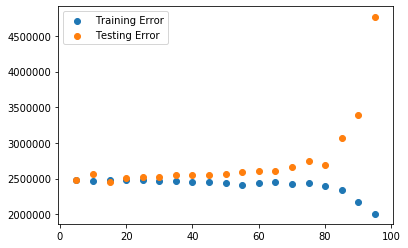

In [94]:
#Evaluate the effect of train-test split 
import random
random.seed(8)
train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

## Cross Validation Score

In [80]:
#Cross Validation Score of top 5 features
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
cv_5_results

array([-20296949.3721899 ,  -1296142.91223449, -23480997.10173826,
        -1177150.94634367, -57626471.37941127])

# Summary

From my EDA, I can conclude that a car's price is indirectly related to it's mileage. And the size of the engine is a good predictor of price since there is a direct relationship.

I tried to use log transformations to remove some of the skewness in the 'mpg' and 'mileage' features but it caused an error in my models - probably because it created negative/zero values.

I also used StandardScaler to fit some data AFTER performing the test/train split.

The Decision Tree and Linear Regressor models had the lowest RMSE.

The OLS Model had a high R^2 value but had too much multicollinearity and high p-values for me to accept this score.

# Future Recommendations

I couldn't get the log transformation to work with the model, even though I felt like a couple of the features were skewed. I'd like to go back and remove some of the features that were causing multicollinearity.